In [1]:
# pip install "dask[diagnostics]"

In [2]:
# pip install dask 

Must be run using deeplearning environment.  This notebook is based off the VGG16 kickoff example done in class.

# Transfer Learning 

Convolutional Neural Network (CNN) to classify x-ray images of lungs. 

**Specifically, we will be leveraging the power of transfer learning to teach the pre-trained NN `keras.applications.VGG16` to classify images of pneumonia versus normal x-rays of lungs.**

The images that we will be using are from kaggle: https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays/data 

In [3]:
# Imports
# The usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import os, sys
import cv2
import joblib
import glob
import dask.bag as bag
import dask.array as da
from dask.diagnostics import ProgressBar
from PIL import Image

# Importing tf tools
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential

from tqdm import tqdm

## Function Definitions

In [4]:
# taken from https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
# however, had to modify this because when called, some of the images in Class 1 were 3 dimenions 
# in terms of the shape of the image
#def get_dims(file):
#    '''Returns dimensions for an RBG image'''
#    im = Image.open(file)
#    arr = np.array(im)
#    h,w = arr.shape
#    return h,w

def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    #im = Image.open(file)
    im = cv2.imread(file,cv2.IMREAD_UNCHANGED)
    arr = np.array(im)
    if len(arr.shape) == 2:
        h,w = arr.shape
    else:
        h,w,d = arr.shape
    return h,w

In [5]:
def dim_count(directory):
    dim2 = 0
    dim3 = 0
    dim0 = 0
    note = directory.split("/")
    '''Checks dimensions of each image in the folder and plots the results'''
    #loop through the directory to get the shape of each image
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            img = cv2.imread(f,cv2.IMREAD_UNCHANGED)
            dimensions = img.shape
            size2 = len(dimensions)
            if size2 == 2:
                dim2 += 1
            elif size2 == 3:
                dim3 += 1
            else:
                dim0 += 1
                
    #Plot the sum of each category of dimensions
    plt.bar(['2 dimensions','3 dimensions', 'Other'],[dim2, dim3, dim0], width = .5);
    plt.title(f'Count of Images per Dimension in the {note[3]} {note[4]} Set');
    plt.xlabel('Number of Dimensions');
    plt.ylabel('# Images');
    print(f'There are {dim2} images with 2 dimensions, {dim3} with 3 and {dim0} with other.')
    return(dim2, dim3)

In [6]:
def max_file_size(directory):
    # Get list of files in a directory
    list_of_files = filter( os.path.isfile, glob.glob(  directory + '/*') )
    # Find the file with max size from the list of files
    max_file = max( list_of_files, key =  lambda x: os.stat(x).st_size)
    print('Max File: ', max_file)
    print('Max File size in bytes: ', os.stat(max_file).st_size)

In [7]:
def min_file_size(directory):
    # Get list of files in a directory
    list_of_files = filter( os.path.isfile, glob.glob(  directory + '/*') )
    # Find the file with max size from the list of files
    min_file = min( list_of_files, key =  lambda x: os.stat(x).st_size)
    print('Min File: ', min_file)
    print('Min File size in bytes: ', os.stat(min_file).st_size)

In [8]:
def plot_count(directory1):

    number_classes = {'Class_0': len(os.listdir(directory1 + 'NORMAL' )), 'Class_1': len(os.listdir(directory1 + 'PNEUMONIA'))}
    plt.figure()
    plt.bar(number_classes.keys(), number_classes.values(), width = .5)
    plt.title("Number of Images by Class")
    plt.xlabel('Class Name')
    plt.ylabel('# Images')
    plt.show()
    print('There are', len(os.listdir(directory1 + 'NORMAL' )), 'Class 0 images and', len(os.listdir(directory1 + 'PNEUMONIA')), 'of Class 1 in folder', directory1 + '.')

## Setting Up the Paths and EDA

In [9]:
# Assigning the relative path of the 'capstone' directory to variable 'path' (so we don't have to keep repeating it)
TRAIN_PATH = './Data/capstone/train/'
TEST_PATH = './Data/capstone/test/'
NORMAL_TRAIN = './Data/capstone/train/NORMAL'
PNEUMONIA_TRAIN = './Data/capstone/train/PNEUMONIA'
NORMAL_TEST = './Data/capstone/test/NORMAL'
PNEUMONIA_TEST = './Data/capstone/test/PNEUMONIA'
directories = {'Class_0_Train': './Data/capstone/train/NORMAL/', 'Class_1_Train': './Data/capstone/train/PNEUMONIA/',
               'Class_0_Val': './Data/capstone/Val/NORMAL/', 'Class_1_Val': './Data/capstone/Val/PNEUMONIA/',
               'Class_0_Test': './Data/capstone/test/NORMAL/', 'Class_1_Test': './Data/capstone/test/PNEUMONIA/'}


### Plot Count of Each Class in Training and Test Folders

In [10]:
# Assign the classes and folders to a dictionary called number of classes
number_classes = {'Class_0': len(os.listdir(NORMAL_TRAIN)),
'Class_1': len(os.listdir(PNEUMONIA_TRAIN))}

In [11]:
# Print the number of objects of Class 0 and 1 in the training folder
print(number_classes.items())

dict_items([('Class_0', 1341), ('Class_1', 3875)])


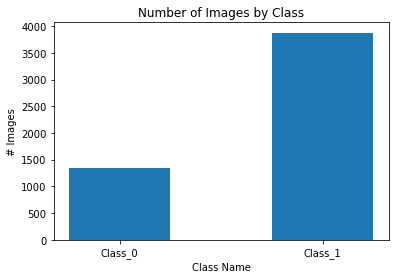

In [12]:
# Plot the distribution of class 0 and class 1 images in the training folder.
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

In [13]:
print('There are', len(os.listdir(NORMAL_TRAIN)), 'Class 0 images and', len(os.listdir(PNEUMONIA_TRAIN)), 'of Class 1 in folder', PNEUMONIA_TRAIN +'.')

There are 1341 Class 0 images and 3875 of Class 1 in folder ./Data/capstone/train/PNEUMONIA.


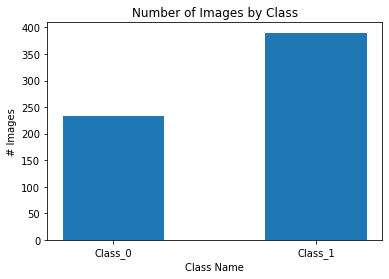

There are 234 Class 0 images and 390 of Class 1 in folder ./Data/capstone/test/.


In [14]:
# Same as above but with using a definition and variable set to the Test folder.
plot_count(TEST_PATH)


In [15]:
# Check what was defined in the directories variable
print(directories.items())

dict_items([('Class_0_Train', './Data/capstone/train/NORMAL/'), ('Class_1_Train', './Data/capstone/train/PNEUMONIA/'), ('Class_0_Val', './Data/capstone/Val/NORMAL/'), ('Class_1_Val', './Data/capstone/Val/PNEUMONIA/'), ('Class_0_Test', './Data/capstone/test/NORMAL/'), ('Class_1_Test', './Data/capstone/test/PNEUMONIA/')])


[########################################] | 100% Completed | 15.05 s
[########################################] | 100% Completed | 13.70 s
[########################################] | 100% Completed | 1.35 ss
[########################################] | 100% Completed | 1.27 ss
[########################################] | 100% Completed | 3.13 ss
[########################################] | 100% Completed | 3.02 ss


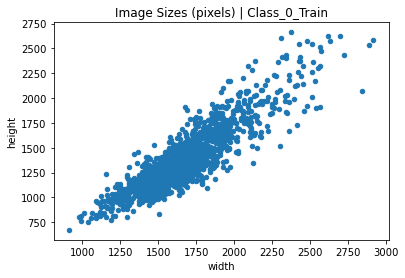

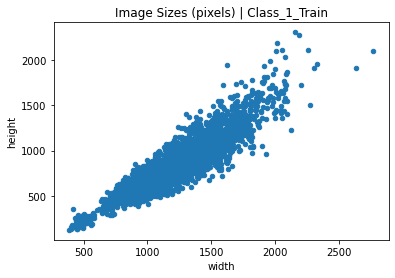

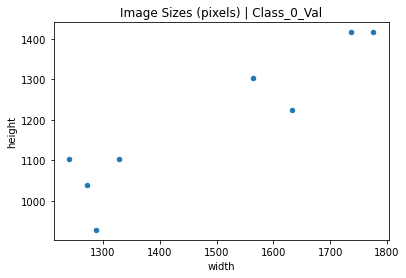

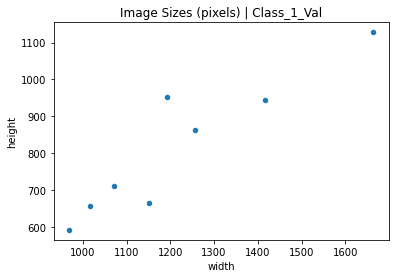

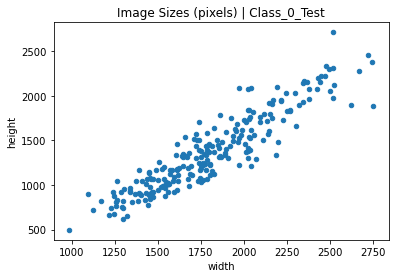

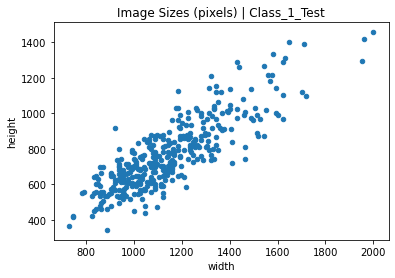

In [16]:
# taken from https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
# This will loop through the directories defined and create a scatter plot of each file based on each class in the directory
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

As the above scatter plots show, the images range in pixels so they will have to be augmented to a consistent size to run in a model.

### Getting Max and Min Size of Files in Training and Test Folders

In [17]:
# taken from https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
for n,d in directories.items():
    filepath = d
    max_file_size(d)

Max File:  ./Data/capstone/train/NORMAL\NORMAL2-IM-1257-0001.jpeg
Max File size in bytes:  2414342
Max File:  ./Data/capstone/train/PNEUMONIA\person279_bacteria_1315.jpeg
Max File size in bytes:  597038
Max File:  ./Data/capstone/Val/NORMAL\NORMAL2-IM-1440-0001.jpeg
Max File size in bytes:  530145
Max File:  ./Data/capstone/Val/PNEUMONIA\person1954_bacteria_4886.jpeg
Max File size in bytes:  119629
Max File:  ./Data/capstone/test/NORMAL\IM-0045-0001.jpeg
Max File size in bytes:  723830
Max File:  ./Data/capstone/test/PNEUMONIA\person16_virus_47.jpeg
Max File size in bytes:  262329


In [18]:
for n,d in directories.items():
    filepath = d
    min_file_size(d)

Min File:  ./Data/capstone/train/NORMAL\NORMAL2-IM-1356-0001.jpeg
Min File size in bytes:  131499
Min File:  ./Data/capstone/train/PNEUMONIA\person325_virus_660.jpeg
Min File size in bytes:  5441
Min File:  ./Data/capstone/Val/NORMAL\NORMAL2-IM-1438-0001.jpeg
Min File size in bytes:  170888
Min File:  ./Data/capstone/Val/PNEUMONIA\person1951_bacteria_4882.jpeg
Min File size in bytes:  49271
Min File:  ./Data/capstone/test/NORMAL\NORMAL2-IM-0256-0001.jpeg
Min File size in bytes:  46174
Min File:  ./Data/capstone/test/PNEUMONIA\person78_bacteria_378.jpeg
Min File size in bytes:  19666


### Checking Dimension of Files in Training and Test Folders

There are 1341 images with 2 dimensions, 0 with 3 and 0 with other.


(1341, 0)

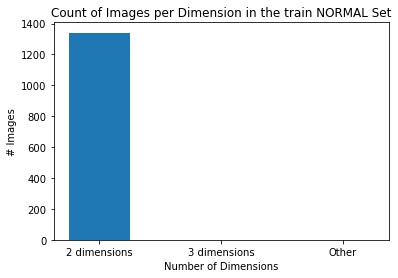

In [19]:
#Set the path the to the Normal training folder
directory = (NORMAL_TRAIN)
dim_count(directory)


There are 3592 images with 2 dimensions, 283 with 3 and 0 with other.


(3592, 283)

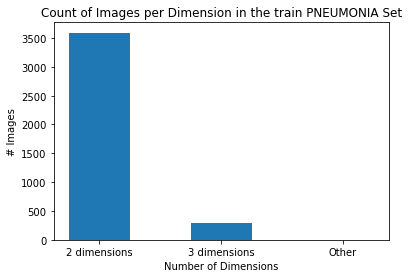

In [20]:
#Set the path the to the Pneumonia folder and plot the results
directory = PNEUMONIA_TRAIN
dim_count(directory)

There are 234 images with 2 dimensions, 0 with 3 and 0 with other.


(234, 0)

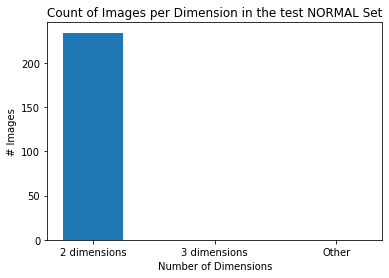

In [21]:
#Set the path the to the Normal training folder
directory = (NORMAL_TEST)
dim_count(directory)


There are 390 images with 2 dimensions, 0 with 3 and 0 with other.


(390, 0)

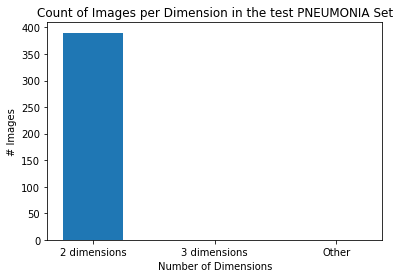

In [22]:
#Set the path the to the Pneumonia test folder
directory = (PNEUMONIA_TEST)
dim_count(directory)


Only the training pneumonia folder had images that were not 2 dimensions so this had to be account for when producing the scatter plot.  Since this project will be using VGG16 as well, the 2 dimensional images have to be converted to RGB format so that the model will accept the images.

## Setting up the Generators
<a id='SettinguptheGenerators'></a>

We will be using [`ImageDataGenerator()` which will do all the preprocessing and random augmentations](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) (e.g., scaling and random rotations, zooming) of the images for us.

Used with [`ImageDataGenerator().flow_from_directory()`](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) it will apply the preprocessing and augmentation on batches of images from the directory we provide the path to. 

We will be feeding the image data into our pre-trained NN in batches by using our created generators. 

In [23]:
# Saving variables that we will be calling on 

# We have 2 classes we are trying to classify
classes = 2

# We will re-size the images to 128 by 128 pixels to cut down on computation time 
pixels = 128

# They are colour images so they have 3 channels 
channels = 3

# We want to work with 20 images at a time (in each batch)
batch_size = 20

First, we'll instantiate the `ImageDataGenerator()`s and set the paramaeters according to the preprocessing and augmentation that we want done to each image. 

In this step we also start setting up the validation size. We can outline the % of images in the batch to set aside for the validation set that will be used for each epoch. 

Note: The validation set was not used because there were not enough images in the set to train.  Instead validation split was set to 10% to use some of the images there in the validation process of the epoch.

In [24]:
# Instantiating the training/validation ImageDataGenerator()
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   fill_mode='reflect',
                                   validation_split=0.1)

In [25]:
# The generator for the training data, shuffle set to True 
train_generator = datagen_train.flow_from_directory('./Data/capstone/train/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False, subset='training') # removed subset='training'

# Generator for validation data, shuffle set to 'False' 
validation_generator = datagen_train.flow_from_directory('./Data/capstone/train/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False,subset='validation') # removed subset='validation'

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [26]:
# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(len(train_generator)/batch_size)-1)): #1st batch is already fetched before the for loop.
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

(220, 128, 128, 3) (220, 2)


In [27]:
type(X_train)

numpy.ndarray

In [28]:
# look at the data contained in the first image of the X_train set.
X_train[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.01220925, 0.01220925, 0.01220925],
        ...,
        [0.23154378, 0.23154378, 0.23154378],
        [0.23834386, 0.23834386, 0.23834386],
        [0.2304804 , 0.2304804 , 0.2304804 ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00649799, 0.00649799, 0.00649799],
        ...,
        [0.21515183, 0.21515183, 0.21515183],
        [0.23371392, 0.23371392, 0.23371392],
        [0.22956051, 0.22956051, 0.22956051]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.0006566 , 0.0006566 , 0.0006566 ],
        ...,
        [0.22597684, 0.22597684, 0.22597684],
        [0.24542212, 0.24542212, 0.24542212],
        [0.23613063, 0.23613063, 0.23613063]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

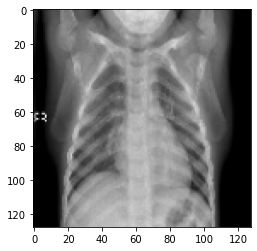

In [29]:
# view one of the images
plt.imshow(X_train[219])

Lastly, we'll get the number of steps that will need to be carried out for each epoch based on our batch_sizes. 

In [30]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size 

valid_stepsize = validation_generator.samples//validation_generator.batch_size

# Sanity check   ' '
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize}')

Training step size = 234 
Validation step size = 26


## Compiling the VGG16 Convolutional Neural Network 

Modified from the *Transfer Learning using Keras* lecture, we will be: 

1. Loading in the trained base model, VGG16, stripping off the top layers of the CNN

2. Hold the trained layers of VGG16 static (i.e., freeze their weights so they can't be re-trained)

3. Set up some additional layers that we **will train** to classify our x-ray image data.

### Step 1

In [31]:
# Import the pretrained VGG16 network, do not include the top layers
pretrained = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))

1. First, we will set `weights` to 'imagenet', recall from our Transfer Learning lecture, ImageNet has pretty much been a standard dataset used for Large Scale Visual Recognition. And Keras has built into it several CNN architectures & weights that were trained on it, including the base model VGG16 we are using today.
2. The second parameter is `include_top = False` gets rid of all the dense layers (i.e. the fully connected ones) and the last layer (the output layer).
3. Since we have gotten rid of the last layer, pooling can be used to down sample the detection of features in feature maps. In this case, we have chosen to add a global max pooling layer, which will will flatten the data.
4. Lastly, specify the input_shape, which we have defined in the variables earlier.

### Step 2

In [32]:
# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained.layers:
    layer.trainable=False

Since we want to make sure we do not change the layers from the pretrained model. We need to make them non-trainable using the `trainable = False` argument. Because otherwise what is the point of transfer learning, since in transfer learning we are just using pre-trained weights and our model only has to learn the weights of the last few layers.

In [33]:
# Display VGG16 architecture
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

We can see that trainable params is zero, which we wanted, and the global_max_pooling layer will flatten the data so it will be ready to be inputed to the full-connected (dense) top layers we will add.

### Step 3 

We will now compile our `pneumonia_model` with the pretrained layers and added top layers that we will train on our x-ray images. 

It's important to note that this is only one of the syntatical ways of implementing transfer learning. 

In [34]:
# Instantiate the NN model 
pneumonia_model = Sequential()

# Add the pretrained layers 
pneumonia_model.add(pretrained)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
pneumonia_model.add(Dense(256, activation='relu'))
pneumonia_model.add(Dropout(0.5))
pneumonia_model.add(Dense(512, activation='relu'))

# Adding our activation 
pneumonia_model.add(Dense(classes, activation='softmax'))

**Fully-connected dense layer**
With the pretrained model, we have already flattened the pooled feature map into a sequential column of numbers. This allows that information to become the input of our fully-connected dense layer, which serves to combine our features into more attributes. These will predict the classes with greater accuracy. 

If, for example, we have three output classes, different types of food, and let's say neuron that reads “0” is absolutely uncertain that the feature belongs to a bowl of ramen. A neuron that reads “1 is absolutely certain that the feature belongs to that bowl. In the final fully connected layer, the neurons will read values between 0 and 1. This signifies different levels of certainty. A value of 0.9 would signify a certainty of 90%.

**Softmax Activation**
And the softmax function serves as an activation function that use the features from the output of these layers to classify the input image based on the training data.

We can also add an [`EarlyStopping()` callback](https://keras.io/api/callbacks/early_stopping/) that will also help prevent our model from being overtrained to our x-ray images. 

In [35]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

1. In this case, we are actually monitoring the validation accuracy.
2. We are setting `patience=5`, which infers that after 5 epochs with no improvement, the training will be stopped.
3. Then we will be setting the `mode` to "auto", which essentially just automatically inferred that for `val_acc`, improvement means increasing values.
3. And then lastly, setting `min_delta` to 0.0001, which is the minimum change in validation accuracy to qualify as an improvement.

We can also set the learning rate with an Adam optimizer, which, as you recall, is a optimization algorithm that computes individual learning rates for different parameters.

In [36]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
pneumonia_model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['acc']) #, tf.keras.metrics.Recall(), 
                                                                              #metrics.AUC()]) # loss was loss='categorical_crossentropy'

# Summary 
pneumonia_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 14,978,626
Trainable params: 263,938
Non-trainable params: 14,714,688
_________________________________________________________________


Just a brief recall on what learning rate is, it is a hyperparameter that controls how much the model should change in response to the estimated error when the model weights are updated.

After we have set it up, we are finally going to compile our final CNN model, setting the optimizer, and then also selecting the loss function and metrics.
1. In this case we will be using the binary_crossentropy as our loss function, as I have a binary class classification problem.
2. And then we are just going to set accuracy score as our metrics.

By using a pre-trained NN we have a lot less parameters to train. 

Not only is this great time-wise, but it is ideal for our data set. We wouldn't have a sufficient amount of data to train 14+ million parameters. 

In [37]:
# Fitting the model to the training data
history = pneumonia_model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=10,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
234/234 [==============================] - 476s 2s/step - loss: 0.4687 - acc: 0.7718 - val_loss: 0.3519 - val_acc: 0.8019
Epoch 2/10
234/234 [==============================] - 468s 2s/step - loss: 0.2995 - acc: 0.8717 - val_loss: 0.2197 - val_acc: 0.9077
Epoch 3/10
234/234 [==============================] - 466s 2s/step - loss: 0.2486 - acc: 0.9003 - val_loss: 0.2123 - val_acc: 0.9000
Epoch 4/10
234/234 [==============================] - 466s 2s/step - loss: 0.2226 - acc: 0.9050 - val_loss: 0.1933 - val_acc: 0.9115
Epoch 5/10
234/234 [==============================] - 466s 2s/step - loss: 0.2004 - acc: 0.9194 - val_loss: 0.1705 - val_acc: 0.9212
Epoch 6/10
234/234 [==============================] - 467s 2s/step - loss: 0.1768 - acc: 0.9275 - val_loss: 0.2018 - val_acc: 0.9135
Epoch 7/10
234/234 [==============================] - 467s 2s/step - loss: 0.1754 - acc: 0.9305 - val_loss: 0.1872 - val_acc: 

In [38]:
# prepare to save the model
model = pneumonia_model
model.save_weights("model.h5")

In [39]:
model.save('Capstone')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Capstone\assets


In [40]:
# check for history object
history.history

{'loss': [0.4687388837337494,
  0.299490749835968,
  0.24858635663986206,
  0.22259898483753204,
  0.20037704706192017,
  0.17676641047000885,
  0.17538678646087646,
  0.17103834450244904,
  0.1570524126291275,
  0.15332552790641785],
 'acc': [0.7717646956443787,
  0.8716577291488647,
  0.900320827960968,
  0.9050267338752747,
  0.9193583130836487,
  0.9274866580963135,
  0.9304812550544739,
  0.9345454573631287,
  0.9386096000671387,
  0.9431015849113464],
 'val_loss': [0.3519434630870819,
  0.21971897780895233,
  0.21233928203582764,
  0.1932767927646637,
  0.1704566776752472,
  0.2018437534570694,
  0.18719495832920074,
  0.1452779769897461,
  0.16154898703098297,
  0.13373404741287231],
 'val_acc': [0.8019230961799622,
  0.9076923131942749,
  0.8999999761581421,
  0.9115384817123413,
  0.9211538434028625,
  0.9134615659713745,
  0.9288461804389954,
  0.9442307949066162,
  0.9384615421295166,
  0.9365384578704834]}

Using the stored values for loss and accuracy in the `history` object:

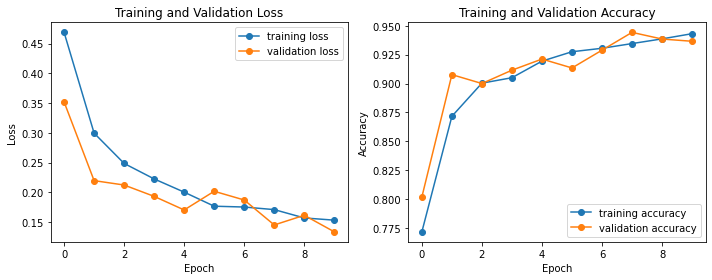

In [41]:
plt.subplots(1,2,figsize =(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], marker='o', label='training loss')
plt.plot(history.history['val_loss'], marker='o', label='validation loss')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['acc'], marker='o', label='training accuracy')
plt.plot(history.history['val_acc'], marker='o', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Validation accuracy is higher than the training accuracy in comparison to the example done in the kickoff.  Perhaps more can be done to optmize the model. 

When you use Dropout, the behaviour when training and validation are different.

When training, only a percentage of the features are used, since we set Dropout to 50%. When validating, all features are used (and are scaled appropriately). So the model at validation time is more robust - and can lead to higher validation accuracies.

We were able to train a CNN all around half an hour! Given the time crunch and small dataset, it would not have been possible for us to produce this decent model without transfer learning.

In [42]:
# print the evaluation score of the training set
print(pneumonia_model.evaluate(X_train,y_train))

7/7 [==============================] - 16s 2s/step - loss: 0.2202 - acc: 0.9318
[0.22017253935337067, 0.9318181872367859]


### Preparing the test data

In [43]:
# Generator for test data, shuffle set to 'False' 
test_generator = datagen_train.flow_from_directory('./Data/capstone/test/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False) # removed subset='validation'

Found 624 images belonging to 2 classes.


In [44]:
# Store the data in X_train, y_train variables by iterating over the batches
test_generator.reset()
X_test, y_test2 = next(test_generator)
for i in tqdm(range(int(len(test_generator)/batch_size)-1)): #1st batch is already fetched before the for loop.
  img, label = next(test_generator)
  X_test = np.append(X_test, img, axis=0 )
  y_test2 = np.append(y_test2, label, axis=0)
print(X_test.shape, y_test2.shape)

0it [00:00, ?it/s]

(20, 128, 128, 3) (20,)


In [45]:
type(X_test)

numpy.ndarray

In [46]:
# Check the shape of the X_test object
X_test.shape

(20, 128, 128, 3)

In [47]:
#Check the type of the test_generator object
type(test_generator)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [48]:
test_generator

In [49]:
# Check the classes of the test set
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [50]:
# Display the labels contained in the test_generator object
test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [51]:
# Check the length of test_generator
len(test_generator.labels)

624

In [52]:
# Assign the labels to y_test to use for metrics
y_test = test_generator.labels

In [53]:
# Display was is stored in y_test
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [54]:
# Reset the generator to the first batch
test_generator.reset()

In [55]:
# Get predictions of the images in the test_generator object
y_pred = pneumonia_model.predict(test_generator)

In [56]:
# Check the type of y_pred
type(y_pred)

numpy.ndarray

In [57]:
# Check the shape of y_pred
y_pred.shape

(624, 2)

In [58]:
# show probabilities of the classes of the image in the array
y_pred

array([[0.52417284, 0.47582722],
       [0.38170323, 0.6182968 ],
       [0.81336075, 0.18663928],
       ...,
       [0.00127807, 0.9987219 ],
       [0.00190478, 0.9980952 ],
       [0.07159751, 0.92840254]], dtype=float32)

In [59]:
# convert the percentages into 0 or 1
predicted_categories = np.argmax(y_pred, axis = -1)

In [60]:
# This will store the highest value but it did not convert to 0 or 1 so it shouldn't be used
np.take_along_axis(y_pred, np.expand_dims(predicted_categories, axis=-1), axis=-1)

array([[0.52417284],
       [0.6182968 ],
       [0.81336075],
       [0.6152985 ],
       [0.8401168 ],
       [0.8737028 ],
       [0.6811218 ],
       [0.8159914 ],
       [0.58081436],
       [0.9337002 ],
       [0.91709876],
       [0.8820901 ],
       [0.9508076 ],
       [0.9515415 ],
       [0.51339   ],
       [0.6182008 ],
       [0.9983631 ],
       [0.7743526 ],
       [0.9695663 ],
       [0.94385517],
       [0.914089  ],
       [0.65316033],
       [0.8524602 ],
       [0.7923797 ],
       [0.9772543 ],
       [0.9468812 ],
       [0.93023807],
       [0.9893114 ],
       [0.83573806],
       [0.65433085],
       [0.71717113],
       [0.51186496],
       [0.81850594],
       [0.99469596],
       [0.93369436],
       [0.93152755],
       [0.97720784],
       [0.7613107 ],
       [0.97342515],
       [0.96712476],
       [0.6691912 ],
       [0.9682721 ],
       [0.9552696 ],
       [0.9961683 ],
       [0.69681996],
       [0.9835259 ],
       [0.50002295],
       [0.719

In [61]:
# Checking the type again for predicted_categories
type(predicted_categories)

numpy.ndarray

In [62]:
# Check was is in predicted_categories
predicted_categories

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [63]:
# Check the length of predicted_categories
len(predicted_categories)

624

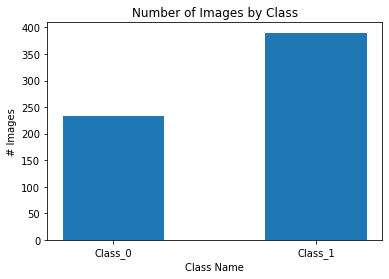

There are 234 Class 0 images and 390 of Class 1 in folder ./Data/capstone/test/.


In [64]:
# Plot the count of images in the test set
plot_count(TEST_PATH)

There are 122 Class 0 and 502 Class 1 predictied images.


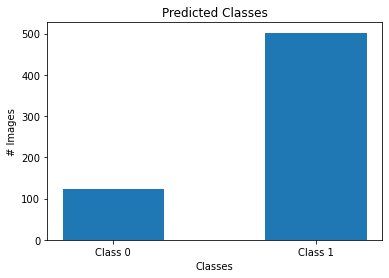

In [118]:
# Plot the count of the predicted classes in the test set
class0 = 0
class1 = 0
for i in range(len(predicted_categories)):
    if predicted_categories[i] == 0:
        class0 += 1
    else:
        class1 += 1
plt.bar(['Class 0','Class 1'],[class0, class1], width = .5);
plt.title(f'Predicted Classes');
plt.xlabel('Classes');
plt.ylabel('# Images');
print(f'There are {class0} Class 0 and {class1} Class 1 predictied images.')    
    
    

In [124]:
print("Difference of Class 1 between the test and predicted sets was:", class1 - np.count_nonzero(y_test==1))

Difference of Class 1 between the test and predicted sets was: 112


In comparison to the original test set, the model predicted higher class 1 images meaning that it flagged more images with pneumonia.  Let's create a confusion matrix to better visualize the results.

In [67]:
from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, predicted_categories)
cf_matrix

array([[118, 116],
       [  4, 386]], dtype=int64)

In [68]:
# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Normal", "Predicted Pneumonia"],
    index=["True Normal", "True Pneumonia"]
)

display(cf_df)

,Predicted Normal,Predicted Pneumonia
True Normal,118,116
True Pneumonia,4,386


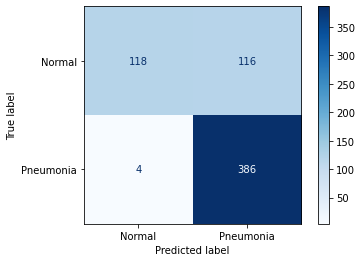

In [69]:
# the function expects the estimator, inputs and target as parameters
# plot_confusion_matrix(pneumonia_model, X_test, y_test); # ValueError: plot_confusion_matrix only supports classifiers so use below instead

labels =["Normal", "Pneumonia"]

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [70]:
report_initial = classification_report(y_test, predicted_categories)
print(report_initial)

              precision    recall  f1-score   support

           0       0.97      0.50      0.66       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.84      0.81      0.79       624



As displayed in the confusion matrix and the classification report, there was a high number of correctly classified images with Pneumonia (Class 1).  However, there were 116 images that were classified as Class 1 as well from the Normal (Class 0) category.  It is also important to note that 4 images of the Class 1 category were predicted to being normal.

Since this problem is about detecting disease and illness of an x-ray image, it is desireable to have a high recall so that the model does not miss true cases or true positives of the Class 1 category at the expense of detecting false negatives of Class 0.  It would be better to detect more false negative so that the images can be verified by a trained professional rather than miss a high number of images that were truly part of Class 1 or in this case, had pneumonia.

Next steps would be to try to use other hyperparameters make the model more accurate in detecting Class 0 vs Class 1 and to also try other parameters in the data augmentation step.  More images would maybe assist as well to better train the model.

In [72]:
# Get evaluation socre of the test set
print(pneumonia_model.evaluate(X_test,y_test2))

1/1 [==============================] - 0s 0s/step - loss: 1.1654 - acc: 0.7000
[1.1653763055801392, 0.699999988079071]


### Bonus: Making Predictions

Our model is trained and ready to go. Now we can take images and ask it to predict whether it is:
- Class 0: Normal
- Class 1: Pneumonia

As a proof of concept we'll just take an image from our training set and pass it through.

You'll need to install [ cv2](https://anaconda.org/anaconda/opencv).

When you have that, import these:

In [73]:
# We'll need a couple more packages to work with images.

# This package lets us import a single image at a time. It's built into matplotlib
import matplotlib.image as mpimg

# Package allowing us to resize an image (jpg/png for example)
#!pip install opencv-python
# import cv2

Now let's choose a file to make a prediction for. We can do that by changing the filepath to the image we'd like to use. 

In [104]:
# Select your image by providing the relative path:
img = mpimg.imread('./Data/capstone/test/NORMAL/IM-0013-0001.jpeg')

In [89]:
img.shape

(2155, 2444)

The image may not be the right size for our model. Remember that it is expecting a 128x128x3 input. Let's resize the images resolution to be 128x128.

In [105]:
# Resize the image to the required resolution of 128 by 128. 
res = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
res = cv2.cvtColor(res,cv2.COLOR_GRAY2RGB)

In [106]:
# turn the image into an array form which is what our model needs as an input. 
pred_img = tf.keras.preprocessing.image.img_to_array(res, data_format=None, dtype=None)

In [107]:
# Run the prediction with our pneumonia_model! 
pneumonia_model.predict(pred_img.reshape(1,128,128,3)) # Reshape for 4D as tensorflow expects.

array([[2.313716e-13, 1.000000e+00]], dtype=float32)

In [93]:
# Check the shape of res to see if was converted to the settings that were applied when resized and changed to RGB
res.shape

(128, 128, 3)

To see confirm that this works, and just out of curiosity, we can take a peek at the resized image.

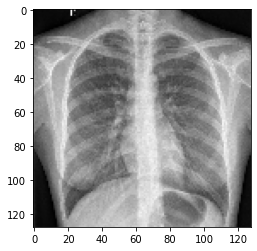

In [108]:
imgplot = plt.imshow(res)

In [95]:
#img2 = mpimg.imread('./Data/capstone/train/pneumonia/person1_bacteria_2.jpeg')

In [96]:
# preparing an image to be predicted for one of the test casess in the Pneumonia class
img2 = mpimg.imread('./Data/capstone/test/PNEUMONIA/person19_virus_50.jpeg')
res2 = cv2.resize(img2, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
res2 = cv2.cvtColor(res2,cv2.COLOR_GRAY2RGB)

In [97]:
# turn the image into an array form which is what our model needs as an input. 
pred_img = tf.keras.preprocessing.image.img_to_array(res2, data_format=None, dtype=None)

In [98]:
# Run the prediction with our pneumonia_model! 
pneumonia_model.predict(pred_img.reshape(1,128,128,3)) # Reshape for 4D as tensorflow expects.

array([[0., 1.]], dtype=float32)

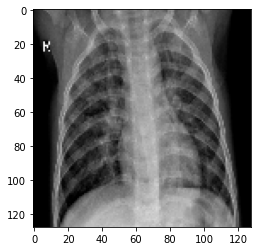

In [112]:
imgplot = plt.imshow(res2)

In [110]:
# Here is an example of an incorrectly predicted normal case
img3 = mpimg.imread('./Data/capstone/test/NORMAL/IM-0013-0001.jpeg')
res3 = cv2.resize(img3, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
res3 = cv2.cvtColor(res3,cv2.COLOR_GRAY2RGB)
pred_img = tf.keras.preprocessing.image.img_to_array(res3, data_format=None, dtype=None)
pneumonia_model.predict(pred_img.reshape(1,128,128,3))

array([[2.313716e-13, 1.000000e+00]], dtype=float32)

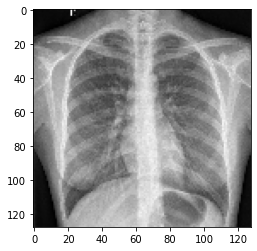

In [111]:
imgplot = plt.imshow(res3)

It is possible that because this x-ray image does not look as clear in the areas of the lungs that the model detected that it was a Class 1 category.  